In [12]:
# importing libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
from transformers.utils import is_torch_device

In [13]:
import torch

In [14]:

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device_name}")

Using device: NVIDIA GeForce RTX 2060 with Max-Q Design


# Creating Gaussian blurs with varying widths and occluding bars

In [15]:
n_gauss = 1000
img_size = 91

x = np.linspace(-4,4,img_size)
X,Y = np.meshgrid(x,x)

#vary widths smoothly
width = np.linspace(2,20,n_gauss)

#initialize tensor containing images
images = torch.zeros(n_gauss,1,img_size,img_size)

for i in range(n_gauss):

    #create the Gaussians with random cetres
    ro = 1.5*np.random.randn(img_size,img_size)/5
    G = np.exp(  -(  (X-ro[0])**2  +  (Y-ro[1])**2)/width[i]  )

    # and add noise
    G = G+np.random.randn(img_size,img_size)/5

    #add a random bar randomly
    i1 = np.random.choice(np.arange(2,28))
    i2 = np.random.choice(np.arange(2,6))
    if np.random.rand()>0:
        G[i1:i1+i2,] =1
    else:
        G[:,i1:i1+i2] =1

    #add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,img_size,img_size)

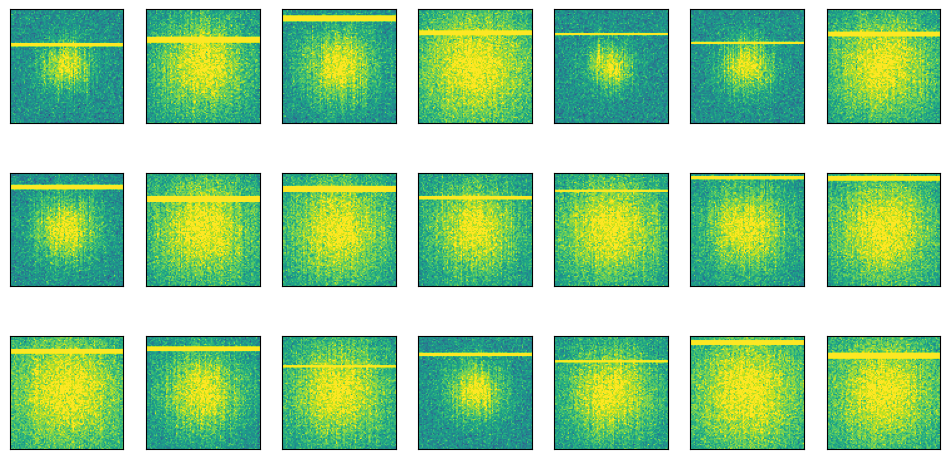

In [16]:
# Visialize some images
fig,axs = plt.subplots(3,7,figsize=(12,6), dpi=100)

for i,ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(n_gauss)
    G = np.squeeze( images[which_pic,:,:])
    ax.imshow(G,vmin=-1,vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Create model

In [17]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

 
torch.Size([10, 1, 91, 91])


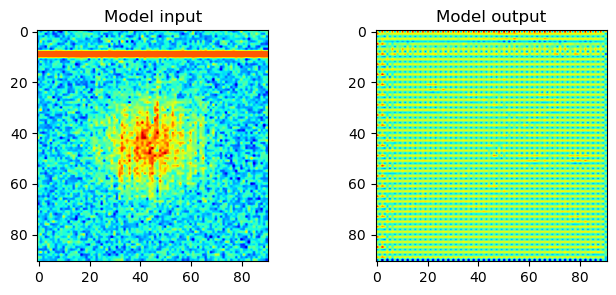

In [18]:
#test the model with one batch
net,lossfun,optimizer = makeTheNet()

y_hat = net(images[:10,:,:,:])

#cheak the size of the output

print(' ')
print(y_hat.shape)

#let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(images[0,:,:,:]).detach(),cmap='jet') #oth image and rest set shape(1,91,91)
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(y_hat[0,:,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [19]:
#count the toall number of parameters
summary(net,(1,img_size,img_size),device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

In [20]:
type(images)

torch.Tensor

# Create a function that trains the model

In [21]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 500

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(n_gauss,size=32,replace=False)
    X = images[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

In [22]:
# test the model on a bit of data
losses,net = function2trainTheModel()

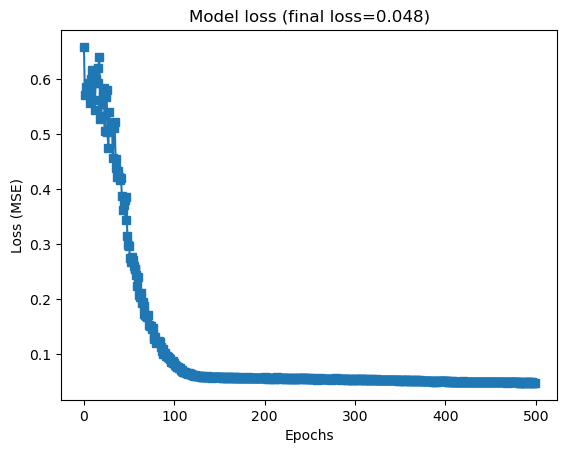

In [23]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

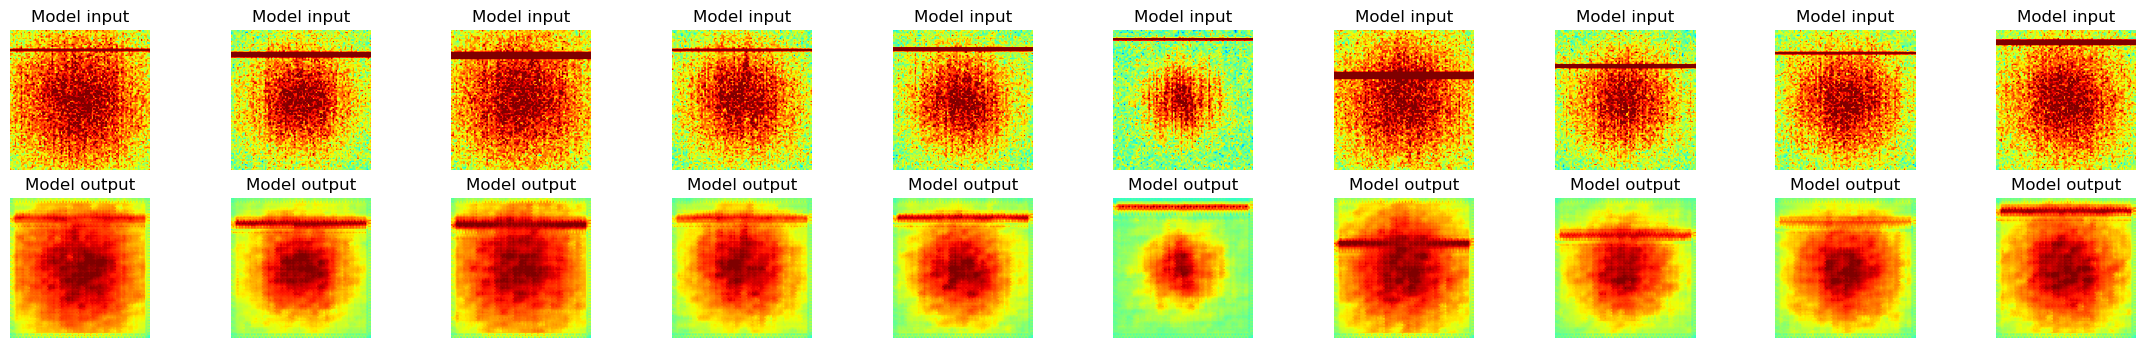

In [24]:
# visualize some images

pics2use = np.random.choice(n_gauss,size=32,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(28,4))

for i in range(10):

  G = torch.squeeze( X[i,0,:,:] ).detach()
  O = torch.squeeze( yHat[i,0,:,:] ).detach()

  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show()

The autoendcoder found out that the bars are important features in the images. It tried to clear up the noises by smooting the images though.

In [25]:

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device_name}")

Using device: NVIDIA GeForce RTX 2060 with Max-Q Design
